## Psych 253: Graph theory and network analysis

A graph is a formal description of a set of things (which we call *nodes*) and a set of relationships between them (which we call *edges*). There are many different types of data that can be represented as a graph, but generally they are of greatest interest in cases where most nodes are not connected to most other nodes; that is, they are *sparse*.  A *network* is mostly just another term for a graph; the field of *network science* is heavily focused on analyzing the structure of large graphs.

In Python there is a package called networkx that provides many tools for the analysis of graphs.  Whereas in the previous lectures we focused on directed graphs, here we will focus on *undirected* graphs -- that is, graphs where the edges don't have a direction. These edges are only meant to reflect a connection, without any claim regarding causality.



In [22]:
import os,sys
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import pickle 
import scipy.stats
import pkg_resources
import sys
import seaborn as sns

# you will need to install the brainnetworks package: pip install brainnetworks
from brainnetworks.utils import get_joint_pubs
DATA_PATH = pkg_resources.resource_filename('brainnetworks', 'data/')

%matplotlib inline

# fix random seeds for networkx
np.random.seed(42)
random.seed(42)

### Example 1: A simple graph

Let's create a graph representing the publication network between a number of neuroscientists.  

Each node in the graph will represent one of the individuals.  First we need to generate the graph object, and then add the nodes.

In [23]:
researchers={'DB':{'name':'Danielle Bassett'},
            'AF':{'name':'Alex Fornito'},
            'MB':{'name':'Michael Breakspear'},
            'SP':{'name':'Steve Petersen'},
            'MC':{'name':'Michael Cole'},
            'JP':{'name':'Jonathan Power'},
            'DF':{'name':'Damien Fair'},
            'AZ':{'name':'Andrew Zalesky'},
            'LC':{'name':'Luca Cocchi'}}

G = nx.Graph()

G.add_nodes_from(researchers)

We can see the nodes using the nodes element in the graph object:

In [24]:
G.nodes

NodeView(('DB', 'AF', 'MB', 'SP', 'MC', 'JP', 'DF', 'AZ', 'LC'))

Each node in the graph can have attributes associated with it, which we can add to the nodes as we would add a dictionary element:

In [25]:
for researcher in researchers:
    G.nodes[researcher]['name']=researchers[researcher]['name']
    print(researcher,G.nodes[researcher])

DB {'name': 'Danielle Bassett'}
AF {'name': 'Alex Fornito'}
MB {'name': 'Michael Breakspear'}
SP {'name': 'Steve Petersen'}
MC {'name': 'Michael Cole'}
JP {'name': 'Jonathan Power'}
DF {'name': 'Damien Fair'}
AZ {'name': 'Andrew Zalesky'}
LC {'name': 'Luca Cocchi'}


Let's visualize the graph so far using Networkx's visualization tools

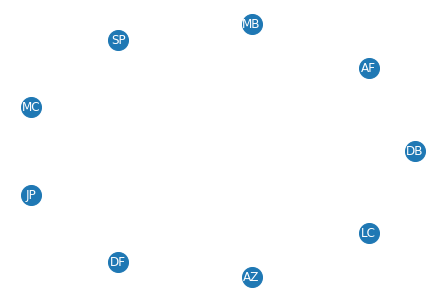

In [26]:
nx.draw_circular(G,with_labels=True,node_size=400,font_color='white')

So far we have a completely disconnected graph - that is, it has no edges (i.e. connections).  Now let's add edges based on the publication history.  First we will generate a matrix containing the number of joint publications between each of the researchers. 

In [27]:
# If the publication data are cached then load those and use them
# instead of getting them from pubmed

pubmed_file = pkg_resources.resource_filename('brainnetworks', 'data/pubmed/pubdata.pkl')
numpubs=pickle.load(open('data/pubmed/pubdata.pkl','rb'))

numpubs

{('DB', 'AF'): 2,
 ('DB', 'MB'): 1,
 ('DB', 'SP'): 1,
 ('DB', 'MC'): 3,
 ('DB', 'JP'): 2,
 ('DB', 'DF'): 0,
 ('DB', 'AZ'): 1,
 ('DB', 'LC'): 0,
 ('AF', 'MB'): 4,
 ('AF', 'SP'): 0,
 ('AF', 'MC'): 0,
 ('AF', 'JP'): 0,
 ('AF', 'DF'): 0,
 ('AF', 'AZ'): 30,
 ('AF', 'LC'): 13,
 ('MB', 'SP'): 0,
 ('MB', 'MC'): 0,
 ('MB', 'JP'): 0,
 ('MB', 'DF'): 0,
 ('MB', 'AZ'): 13,
 ('MB', 'LC'): 7,
 ('SP', 'MC'): 1,
 ('SP', 'JP'): 28,
 ('SP', 'DF'): 15,
 ('SP', 'AZ'): 0,
 ('SP', 'LC'): 0,
 ('MC', 'JP'): 2,
 ('MC', 'DF'): 0,
 ('MC', 'AZ'): 0,
 ('MC', 'LC'): 0,
 ('JP', 'DF'): 3,
 ('JP', 'AZ'): 0,
 ('JP', 'LC'): 0,
 ('DF', 'AZ'): 0,
 ('DF', 'LC'): 0,
 ('AZ', 'LC'): 25}

In [28]:
# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list=list(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df=pd.DataFrame(np.zeros((len(researchers),
                                 len(researchers))),
                   index=researchers_list,
                   columns=researchers_list)

# we just fill in the upper triangle of the matrix
for i,j in enumerate(researchers_list):
    for k in range(i,len(researchers_list)):
        if i==k:
            continue
        df.loc[j][k]=numpubs[(j,researchers_list[k])]

print(df)

     DB   AF   MB   SP   MC    JP    DF    AZ    LC
DB  0.0  2.0  1.0  1.0  3.0   2.0   0.0   1.0   0.0
AF  0.0  0.0  4.0  0.0  0.0   0.0   0.0  30.0  13.0
MB  0.0  0.0  0.0  0.0  0.0   0.0   0.0  13.0   7.0
SP  0.0  0.0  0.0  0.0  1.0  28.0  15.0   0.0   0.0
MC  0.0  0.0  0.0  0.0  0.0   2.0   0.0   0.0   0.0
JP  0.0  0.0  0.0  0.0  0.0   0.0   3.0   0.0   0.0
DF  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0
AZ  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  25.0
LC  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0


Now let's use the co-publication matrix to generate a binary adjacency matrix, which will represent whether there is a link between each pair of investigators.  This is obtained by thresholding the co-publication matrix; for now we will just threshold at greater than zero, so that any publications are sufficient to create an edge.

In [29]:
threshold=0
adjacency_mtx=(df>threshold).astype('int')
print(adjacency_mtx)

    DB  AF  MB  SP  MC  JP  DF  AZ  LC
DB   0   1   1   1   1   1   0   1   0
AF   0   0   1   0   0   0   0   1   1
MB   0   0   0   0   0   0   0   1   1
SP   0   0   0   0   1   1   1   0   0
MC   0   0   0   0   0   1   0   0   0
JP   0   0   0   0   0   0   1   0   0
DF   0   0   0   0   0   0   0   0   0
AZ   0   0   0   0   0   0   0   0   1
LC   0   0   0   0   0   0   0   0   0


Now let's use the adjacency matrix to determine which pairs have an edge, and then add those to the graph.

In [30]:
matches=np.where(adjacency_mtx>0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

Now we can see the edges as part of the graph object:

In [31]:
G.edges

EdgeView([('DB', 'AF'), ('DB', 'MB'), ('DB', 'SP'), ('DB', 'MC'), ('DB', 'JP'), ('DB', 'AZ'), ('AF', 'MB'), ('AF', 'AZ'), ('AF', 'LC'), ('MB', 'AZ'), ('MB', 'LC'), ('SP', 'MC'), ('SP', 'JP'), ('SP', 'DF'), ('MC', 'JP'), ('JP', 'DF'), ('AZ', 'LC')])

And we can now visualize the graph with the edges included.

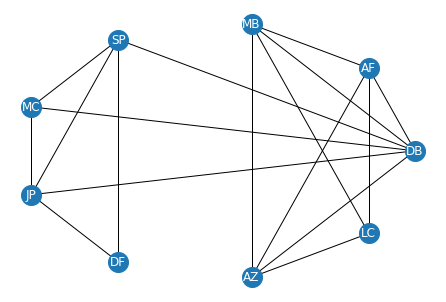

In [32]:
nx.draw_circular(G,with_labels=True,node_size=400,font_color='white')

The circular graph is not very useful because it's hard to see the structure of the network, because the edges are ordered arbitrarily (by the order in which we added them to the network).  Instead let's draw it using a spring embedding algorithm, which treats each edge as a spring and tries to minimize the force exerted on all of the springs taken together. 

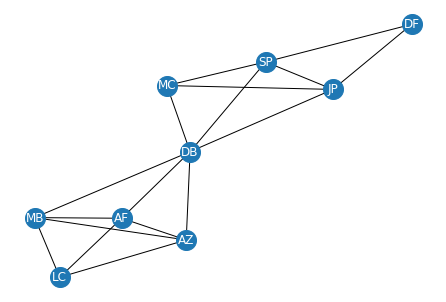

In [33]:
nx.draw_spring(G,with_labels=True,node_size=400,font_color='white')

### Node characteristics

Now that the graph is generated, we can examine the characteristics of some of the nodes.  First, let's look at the number of edges for each node - that is, its *degree*. This is stored in the degree element within the graph object.

In [34]:
G.degree

DegreeView({'DB': 6, 'AF': 4, 'MB': 4, 'SP': 4, 'MC': 3, 'JP': 4, 'DF': 2, 'AZ': 4, 'LC': 3})

We could also compute the degree by summing the adjacency matrix.  We first need to make it a symmetric matrix (since above we only included the upper triangle of the matrix) - we can do that by adding its transpose to the original matrix, and then summing across rows to get the degree.

In [35]:
adjacency_mtx_symm=adjacency_mtx+adjacency_mtx.T
adjacency_mtx_symm['degree']=adjacency_mtx_symm.sum(1)
print(adjacency_mtx_symm)

    DB  AF  MB  SP  MC  JP  DF  AZ  LC  degree
DB   0   1   1   1   1   1   0   1   0       6
AF   1   0   1   0   0   0   0   1   1       4
MB   1   1   0   0   0   0   0   1   1       4
SP   1   0   0   0   1   1   1   0   0       4
MC   1   0   0   1   0   1   0   0   0       3
JP   1   0   0   1   1   0   1   0   0       4
DF   0   0   0   1   0   1   0   0   0       2
AZ   1   1   1   0   0   0   0   0   1       4
LC   0   1   1   0   0   0   0   1   0       3


It's also common to present the adjacency matrix as an image, with the color scale (usually black/white) denoting the presence/absence of connections. Note that by default we set the diagonal (i.e. self-connections) to zero.

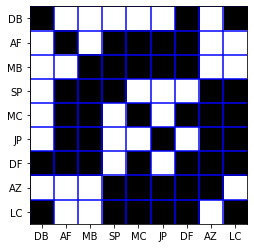

In [36]:
plt.imshow(adjacency_mtx+adjacency_mtx.T,cmap='gray')

# set the axes to use name labels rather than numbers
ax=plt.gca()
ax.set_yticks(np.arange(len(researchers_list)))
ax.set_xticks(np.arange(len(researchers_list)))
ax.set_xticklabels(researchers_list)
ax.set_yticklabels(researchers_list)
# add grid lines
for i in range(len(researchers_list)):
    ax.axvline(x=i-0.5,color='b')
    ax.axhline(y=i-0.5,color='b')

## Example 2: A realistic network

In this example we will use data from the myconnectome study to look at brain connectivity.



In [62]:
import h5py
from pathlib import Path

basedir = Path('/Users/poldrack/data_unsynced/myconnectome_July2')

hdf5file = basedir / 'myconnectome_rsfmri.hdf5'

with h5py.File(hdf5file,'r') as f:
    regions = f['parcellation']['region'][()]
    hemis = f['parcellation']['hemis'][()]
    power_network = f['parcellation']['power_network'][()]
    yeo7networks = f['parcellation']['yeo7networks'][()]

    cc_triu = f['meancorr']['meancorr'][()]
    cc = np.zeros((630, 630))
    cc[np.triu_indices_from(cc, 1)] = cc_triu


    
labels = [f'{i}_{j}_{k}' for i, j, k in zip(hemis, power_network, regions)]
cc_full = pd.DataFrame(
    cc + cc.T + np.eye(cc.shape[0]),
    index=labels, columns=labels)
#sns.clustermap(cc_full, method='ward')

Threshold for 5 density: 0.40


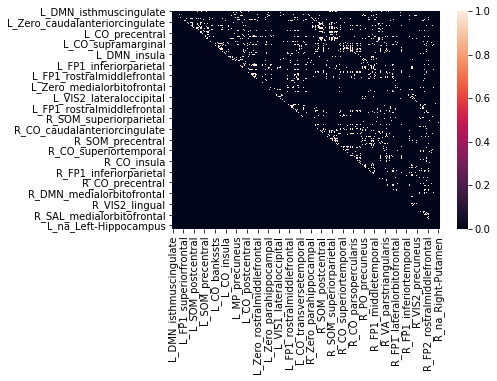

In [63]:
density = 5 # percent connections to keep
thresh = scipy.stats.scoreatpercentile(cc_triu, 100 - density)
print(f'Threshold for {density} density: {thresh:0.2f}')

adj = pd.DataFrame(
    (cc >= thresh).astype(int),
    index=labels,
    columns=labels)
sns.heatmap(adj)

In [64]:
G = nx.Graph()

node_names = adj.columns.tolist()

adjacencies = np.where(adj.values)

for i in range(adjacencies[0].shape[0]):
    G.add_edge(adjacencies[0][i], adjacencies[1][i])

# add labels for nodes
for i in G.nodes:
    G.nodes[i]['name'] = labels[i]
    G.nodes[i]['power_network'] = power_network[i]

for Gcomp in nx.connected_components(G):
    print(len(Gcomp))
    
# extract the giant component

Gc_fmri = G.subgraph(max(nx.connected_components(G), key=len)).copy() 

567
2
2
8
2
4


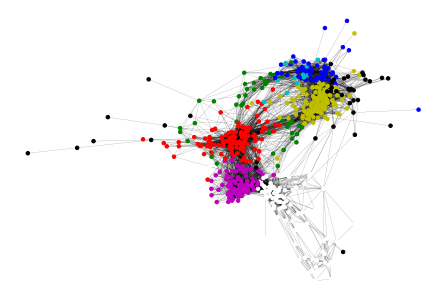

In [65]:
# use existing networks to color edges

node_color_dict = {
    'CO': 'r', 
    'DA': 'g', 
    'DMN': 'b', 
    'FP1': 'y', 
    'FP2': 'y', 
    'MP': 'k', 
    'PO': 'k', 
    'SAL': 'c', 
    'SOM': 'm', 
    'VA': 'g',
    'VIS1': 'w', 
    'VIS2': 'w',
    'Zero': 'k', 
    'na': 'k'
}

node_colors = [node_color_dict[i] for i in power_network[[j for j in Gc_fmri.nodes]]]

# networkx uses a combination of numpy and random, need to set both seeds
seed = 123
random.seed(seed)
np.random.seed(seed)

# generate the layout separately, so we can reuse it below
spring_layout = nx.spring_layout(Gc_fmri)

# draw the graph using power network colors
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=12,
        width=0.1,
        node_color=node_colors)

## Degree distribution



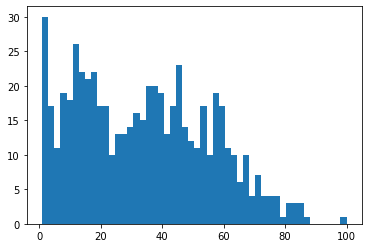

In [91]:
degree = [degree_dict[i] for i in dict(nx.degree(G))]

_ = plt.hist(degree, 50)

This distribution is slightly long-tailed but far from the power-like distributions often seen with some real-world networks.  For example, here is the degree distribution from a Facebook 

mean degree: 43.69101262688784
max degree: 1045


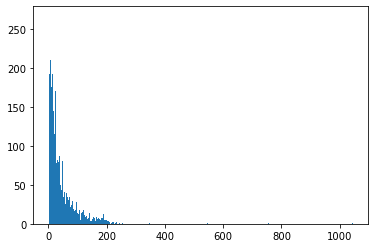

In [93]:
import pkg_resources
facebook_file = pkg_resources.resource_filename('brainnetworks', 'data/facebook/facebook_combined.txt')

facebook_data=pd.read_csv(facebook_file,sep=' ',
                             header=None)
# generate a networkx graph
G_facebook=nx.Graph()
for i in facebook_data.index:
    G_facebook.add_edges_from([tuple(facebook_data.loc[i])])

d = nx.degree(G_facebook)
degree_vals = [G_facebook.degree[i] for i in G_facebook.nodes]
degree_dist = plt.hist(degree_vals,500)
print('mean degree:',np.mean(degree_vals))
print('max degree:',np.max(degree_vals))


### Community detection methods

First let's create a simple graph that has two communities, each of which is fully connected, with one node from each community connected to a node in the other community.

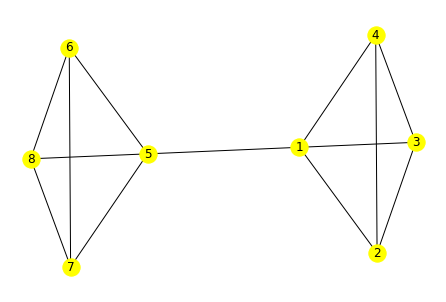

In [41]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges=[(1,2),(1,3),(1,4),(1,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8),(2,3),(2,4),(3,4)]
G.add_edges_from(edges)

nx.draw_spring(G,with_labels=True,node_color='yellow')

### Girvan-Newman method

The Girvan-Newman method is a *divisive* clustering method, meaning that it starts with the full graph and tries to find the best way to divide it into some number of clusters by removing particular edges.

The algorithm was defined by [Girvan & Newman (2002)](http://www.pnas.org/content/99/12/7821) as follows:

1. Calculate the betweenness for all edges in the network.
2. Remove the edge with the highest betweenness.
3. Recalculate betweennesses for all edges affected by the
removal.
4. Repeat from step 2 until no edges remain.

Let's implement this for the example dataset, finding two clusters.

In [44]:
import operator 
import itertools

n_clusters=len([i for i in nx.connected_components(G)])
G_tmp=G.copy()  # make a copy of the graph to work with
while n_clusters==1:
    # step 1: compute edge betweenness
    eb=nx.edge_betweenness(G_tmp)
    
    # step 2: remove the edge with highest betweeness
    # find the edge with the largest value of edge betweenness
    ebmax = max(eb.items(), key=operator.itemgetter(1))[0]
    # remove it from the graph
    G_tmp.remove_edges_from([ebmax])
    print('removing edge:',ebmax)
    
    # compute the number of connected components to see if we have
    # induced new clusters, and continue looping if not
    n_clusters=len([i for i in nx.connected_components(G_tmp)])
    
print('found two clusters:')
Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
print([list(G.subgraph(i).nodes) for i in nx.connected_components(G_tmp)])

removing edge: (1, 5)
found two clusters:
[[1, 2, 3, 4], [5, 6, 7, 8]]


### Modularity

One of the most commonly used set of methods for community detection rely upon the concept of *modularity*.  Here we will walk through the computation of modularity for a simple graph.

Here is one expression for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

To compute modularity for our example graph (which looks to be fairly modular), we first need the adjacency matrix.

In [45]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0.]]


Next we need to generate the $\delta$ matrix denoting whether each pair of vertices is a member of the same community.

In [46]:
partition = [1,1,1,1,2,2,2,2]
delta = np.zeros((len(partition),len(partition)))
for i in range(len(partition)):
    for j in range(len(partition)):
        delta[i,j]=int(partition[i]==partition[j])
        
print(delta)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


The final thing we need is the expected edge frequency from the null model.  In general we want the null model to match the actual graph as closely as possible, except for the clustering. It is common to use a null model in which the degree sequence (i.e. the values of degrees for all nodes) is identical to the real graph; this is a more stringent null model than simply equating the degree distribution.  This null model can be written as (Fortunato, 2010):

$$
Q = \frac{1}{2m}\sum_{ij}\bigg(A_{ij} - \frac{k_i k_j}{2m}\bigg)\delta(C_i,C_j)
$$

where $k_i$ is the degree of vertex $i$.  Note that this null model will not necessarily give an identical degree sequence on any particular realization, but should be the same on average.

In [47]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
Q=0
for i in range(len(k)):
    for j in range(len(k)):
        Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
Q = Q/(2*m)

print(Q)

0.42307692307692296


We can compare our answer to the one given by the built-in modularity function in NetworkX:

In [48]:
assert Q == nx.algorithms.community.quality.modularity(G,
                                            [{1,2,3,4},{5,6,7,8}])

Now let's examine how modularity varies with the partition.  In this case, we can fairly easily compute all 128 possible partitions of the 8 nodes and compute modularity for each.  In principle we should see that the modularity value is highest for the true partition.

In [50]:
from brainnetworks.utils import algorithm_u

Qvals_all=np.zeros(128)
partitions=[]

# loop through all possible partitions of edges into two communities:
for i,p in enumerate(algorithm_u([1,2,3,4,5,6,7,8],2)):
    Qvals_all[i] = nx.algorithms.community.quality.modularity(G,p)
    partitions.append(p)

maximum Q: 0.42307692307692296
best partition: [[1, 2, 3, 4], [5, 6, 7, 8]]


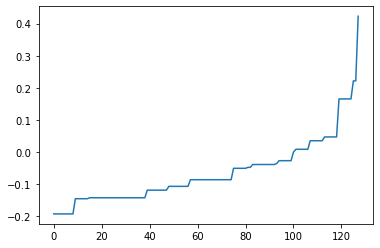

In [51]:
plt.plot(np.sort(Qvals_all))
print('maximum Q:',np.max(Qvals_all))
print('best partition:',partitions[np.argsort(Qvals_all)[-1:][0]])

### Modularity optimization

In general, it's not possible to perform exhaustive computation of modularity for all possible partitions (since the number of possible partitions grows exponentially with the size of the graph), so a number of researchers have developed approximate methods that perform well in finding the partition with the maximum modularity value.

#### Greedy optimization

One approach (proposed initially by [Newman, 2004](https://pdfs.semanticscholar.org/29d4/dfae2807a67a2c66c720b4985cb599c4e245.pdf)) is to perform an *agglomerative* clustering using a ["greedy" algorithm ](https://en.wikipedia.org/wiki/Greedy_algorithm)- that is, an algorithm that makes the best possible choice at each point in the process, akin to climbing a hill by going the steepest upward direction at every point.

In Newman's greedy method, we start with each vertex in its own partition. We then find which combination of partitions would increase modularity the most, and combine those into one.

The implementation here would be far too inefficient to use with real data, but should help make clear how the algorithm works.

In [52]:
# create a function to compute modularity more easily
def modularity(G,partition):
    A = nx.to_numpy_array(G)
    m = len(G.edges)
    delta = np.zeros((len(partition),len(partition)))
    for i in range(len(partition)):
        for j in range(len(partition)):
            delta[i,j]=int(partition[i]==partition[j])
   
    k = [G.degree[i] for i in G.nodes] # degree values
    Q=0
    for i in range(len(k)):
        for j in range(len(k)):
            Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
    Q = Q/(2*m)
    return(Q)

Qvals=[-np.inf]
notbest=True
partition=np.array([1,2,3,4,5,6,7,8])  # initially assign all to the same

while notbest:
    unique_partitions=np.unique(partition)
    print('unique partitions:',unique_partitions)
    # loop through all combinations of unique partitions
    modvals={}
    for i in range(len(unique_partitions)):
        for j in range(i+1,len(unique_partitions)):
            if i==j:
                continue
            tmp_part=np.array(partition)
            tmp_part[tmp_part==unique_partitions[i]]=unique_partitions[j]
            
            modvals[(unique_partitions[i],unique_partitions[j])]=modularity(G,tmp_part)
    modmax = max(modvals.items(), key=operator.itemgetter(1))[0]
    
    # this method assumes that Q increases monotonically to its maximum
    if modvals[modmax]<np.max(np.array(Qvals)):
        print('breaking: found best Q value!')
        print(partition)
        notbest=False
    else:
        print('collapsing:',modmax,modvals[modmax])
        partition[partition==modmax[0]]=modmax[1]
        print('new partition:',partition)
        print('')
        Qvals.append(modvals[modmax])

unique partitions: [1 2 3 4 5 6 7 8]
collapsing: (2, 3) -0.07692307692307693
new partition: [1 3 3 4 5 6 7 8]

unique partitions: [1 3 4 5 6 7 8]
collapsing: (3, 4) 0.02366863905325443
new partition: [1 4 4 4 5 6 7 8]

unique partitions: [1 4 5 6 7 8]
collapsing: (1, 4) 0.14792899408284027
new partition: [4 4 4 4 5 6 7 8]

unique partitions: [4 5 6 7 8]
collapsing: (6, 7) 0.19822485207100599
new partition: [4 4 4 4 5 7 7 8]

unique partitions: [4 5 7 8]
collapsing: (7, 8) 0.2988165680473374
new partition: [4 4 4 4 5 8 8 8]

unique partitions: [4 5 8]
collapsing: (5, 8) 0.42307692307692296
new partition: [4 4 4 4 8 8 8 8]

unique partitions: [4 8]
breaking: found best Q value!
[4 4 4 4 8 8 8 8]


### Spectral clustering

Another common method for community detection is spectral clustering, which uses the eigenvectors of matrices that describe the graph.  While we could work with the adjacency matrix, it is more common to use the [Laplacian matrix](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/), which you can think of as describing the flow of some quantity away from any particular node in the graph.

The Laplacian L is defined as:

$$
L = D - A
$$ 

where $A$ is the adjacency matrix, and $D$ is a diagonal matrix where each entry is the degree of that particular node. Here it is for our example graph:

In [53]:
D = np.zeros(A.shape)
D[np.diag_indices_from(D)]=k
L = D - A
print(L)

[[ 4. -1. -1. -1. -1.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  3.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1. -1. -1.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.  3.]]


In general, it's more useful to work with the normalized Laplacian, which normalizes by degree. We can compute this easily using linear algebra:

$$
Ln = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}
$$

In [54]:
Ln = np.linalg.inv(np.sqrt(D)).dot(L).dot(np.linalg.inv(np.sqrt(D)))
print(Ln)

[[ 1.         -0.28867513 -0.28867513 -0.28867513 -0.25        0.
   0.          0.        ]
 [-0.28867513  1.         -0.33333333 -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.25        0.          0.          0.          1.         -0.28867513
  -0.28867513 -0.28867513]
 [ 0.          0.          0.          0.         -0.28867513  1.
  -0.33333333 -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
   1.         -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
  -0.33333333  1.        ]]


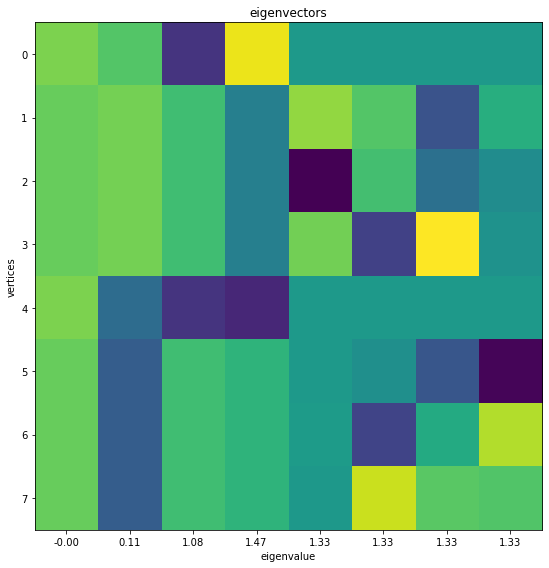

In [55]:
eig = np.linalg.eig(Ln)
def plot_eig(eig):
    plt.figure(figsize=(8,8))
    plt.imshow(eig[1])       # Get locations and labels
    _=plt.xticks([i for i in range(len(eig[0]))], ['%0.2f'%i for i in eig[0]])
    plt.xlabel('eigenvalue')
    plt.ylabel("vertices")
    plt.title('eigenvectors')
    plt.tight_layout()
    
plot_eig(eig)

Note that there is a single zero eigenvalue, which represents the fact that there is a single graph component.  Let's see what would happen if we were to add another component:

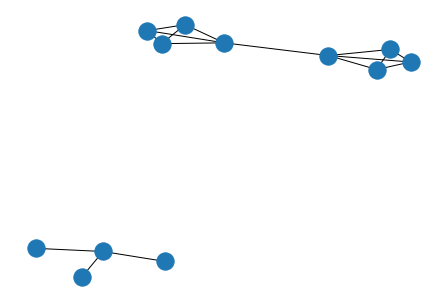

In [56]:
G_bigger = G.copy()
G_bigger.add_edges_from([(9,10),(10,11),(10,12)])
nx.draw_spring(G_bigger)

Now let's get the Laplacian matrix (this time using the built-in NetworkX function) and compute its eigenvalues.

In [57]:
Ln_bigger = nx.normalized_laplacian_matrix(G_bigger).todense()
eig_bigger=np.linalg.eig(Ln_bigger)
eig_bigger[0]

array([-2.77555756e-17,  1.13382475e-01,  1.08333333e+00,  1.46995086e+00,
        1.33333333e+00,  1.33333333e+00,  1.33333333e+00,  1.33333333e+00,
        2.00000000e+00,  1.00000000e+00, -1.00275610e-16,  1.00000000e+00])

Here you can see that there are two zero-valued eigenvalues, reflecting the fact that there are two components.

Now look back at the second column in the eigenvector matrix above, corresponding to the second largest eigenvalue.  Let's draw the graph and color the nodes according to the values of this second smallest eigenvalue:

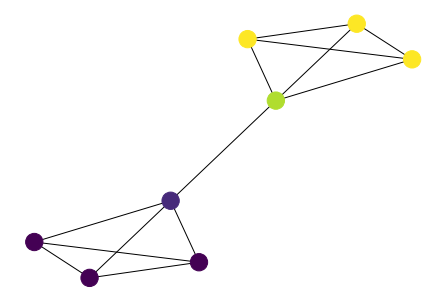

In [58]:
nx.draw_spring(G,node_color=eig[1][:,1],cmap='viridis')

What this shows is that the eigenvector corresponding to the smallest nonzero eigenvalue of the Laplacian matrix divides the graph by its major communities.

Spectral clustering methods take this approach further by treating each vertex in a metric space defined by the eigenvectors, and then using these to perform various clustering operations (e.g., k-means clustering).

## Community detection on the Myconnectome data


In [66]:
# community detection

from brainnetworks.utils import nx_to_igraph,module_degree_zscore,participation_coefficient

ig = nx_to_igraph(Gc_fmri) 

ml=ig.community_multilevel()
communities=np.unique(ml.membership)
print('Louvain method found %d communities'%len(communities))
print(f'modularity = {ml.modularity}')

Louvain method found 5 communities
modularity = 0.6056401150777868


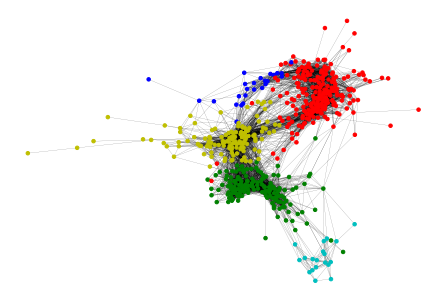

In [67]:
louvain_colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'w']
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=12,
        width=0.1,
        node_color=[louvain_colors[i] for i in ml.membership])

In [68]:
ml.modularity

0.6056401150777868

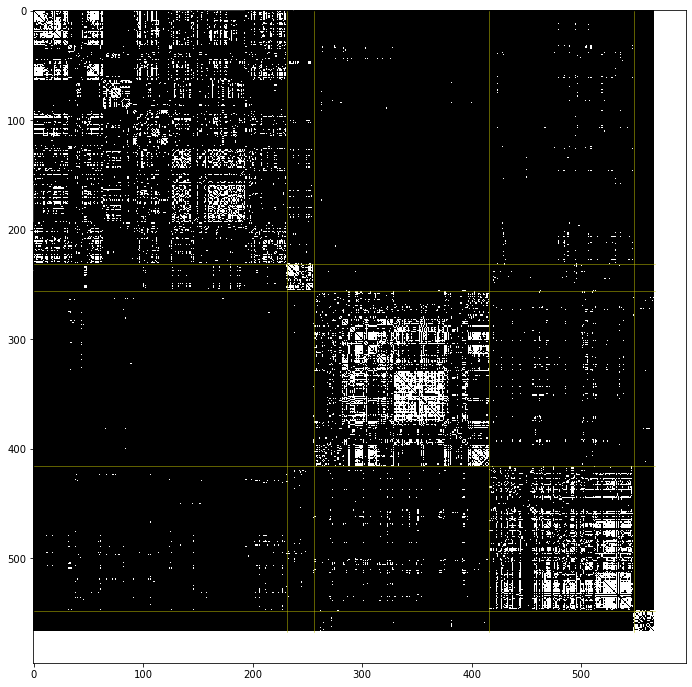

In [69]:
plt.figure(figsize=(12,12))
adjacency_mtx=nx.to_numpy_array(Gc_fmri)
module_idx=np.argsort(ml.membership)
membership_sorted=np.array(ml.membership)[module_idx]
adjacency_mtx_sorted=adjacency_mtx[:,module_idx]
adjacency_mtx_sorted=adjacency_mtx_sorted[module_idx,:]
plt.imshow(adjacency_mtx_sorted,cmap='gray')

# draw lines to demarcate modules
for i in range(1,len(membership_sorted)):
    if membership_sorted[i]!=membership_sorted[i-1]:
        plt.plot([0,len(membership_sorted)],[i,i],color='y',linewidth=0.5)
        plt.plot([i,i],[0,len(membership_sorted)],color='y',linewidth=0.5)

## Node-level characteristics

### Node-level features

So far we have focused on features that describe the entire graph, like average clustering or average path length.  However, we are often also interested in describing the features of individual nodes in the network, which can be useful for describing their role.  In particular, we often want to characterize which are the most important nodes in the network, which is defined in graph theory by the concept of [Centrality](https://en.wikipedia.org/wiki/Centrality).  There are a number of other ways that centrality can be defined, which have been described as falling along two main dimensions (Borgatti & Everett, 2006).  First, we can divided measures based on the type of nodal involvement, between the paths that start or end at a particular node (known as *radial* centralities) and those that are based on the paths that go through a particular node (known as *medial* centralities).  Second, we can divide measures based on the quantity being assessed, either volume (e.g. number of connections) or length (e.g. distance between nodes).

When thinking about centrality measures it is important to keep in mind that different measures are sensitive to different aspects of a network, and they may not agree. 

A simple measure of centrality is *degree centrality* - which is simply the degree of the node (as we discussed earlier in the context of the Facebook dataset). This is a simple measure but can be quite useful in identifying which individuals are connected to the largest number of others.

Another measure of centrality is *closeness centrality* which is based on the average path length from a given node to all other nodes in the network.  This tells us which nodes have the potential to most quickly influence the rest of the network.

Yet another measure is *betweenness centrality*, which is based on the number of times that a node falls on the shortest path between two other nodes.  This tells us which nodes could potentially exert the strongest control on information flow over the network.

Finally, another popular measure is *eigenvector centrality*, which is related to degree centrality but instead of weighting each edge the same way, it provides more credit to nodes that are connected to other highly connected nodes.  Eigenvector centrality is closely related to the PageRank algorithm which is the basis for Google's search algorithms.

Let's compute all of these for the Facebook data - because these can take quite a while to compute, we will cache the results.


In [70]:
centrality={}
centrality['degree'] = nx.degree_centrality(Gc_fmri)
centrality['closeness'] = nx.closeness_centrality(Gc_fmri)
centrality['betweenness'] = nx.betweenness_centrality(Gc_fmri)
centrality['eigenvector'] = nx.eigenvector_centrality(Gc_fmri)
# save to data frame
centrality_df = pd.DataFrame(centrality)

Now let's look at how these different centrality measures are related to one another. Since these measures should really only be treated as ordinal (i.e. relative) variables, we will use rank correlation to compare them.

In [71]:
centrality_cc=centrality_df.corr(method='spearman')
centrality_cc

,degree,closeness,betweenness,eigenvector
degree,1.000000,0.646611,0.514927,0.692896
closeness,0.646611,1.000000,0.693094,0.753438
betweenness,0.514927,0.693094,1.000000,0.334861
eigenvector,0.692896,0.753438,0.334861,1.000000


We see that they are moderately correlated, suggesting that the different measures do indeed provide different information.  Let's plot the network using these indices to see if we can tell how they differ.

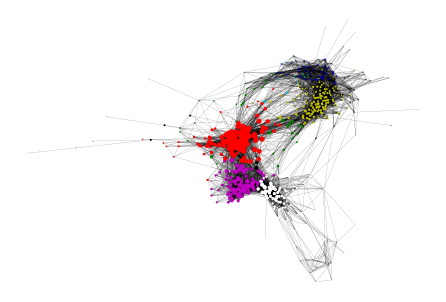

In [72]:
base_size=200
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=[base_size*i for i in centrality_df.loc[:, 'eigenvector']],
        width=0.1,
        node_color=node_colors)

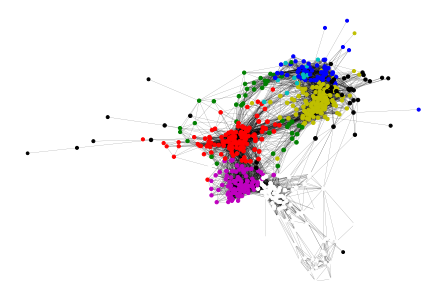

In [74]:
base_size=40
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=[base_size*i for i in centrality_df.loc[:, 'closeness']],
        width=0.1,
        node_color=node_colors)

In [78]:
mdzs=module_degree_zscore(Gc_fmri, ml.membership)
pc=participation_coefficient(Gc_fmri,ml.membership)

Text(0.825, 9.1, 'Kinless hubs')

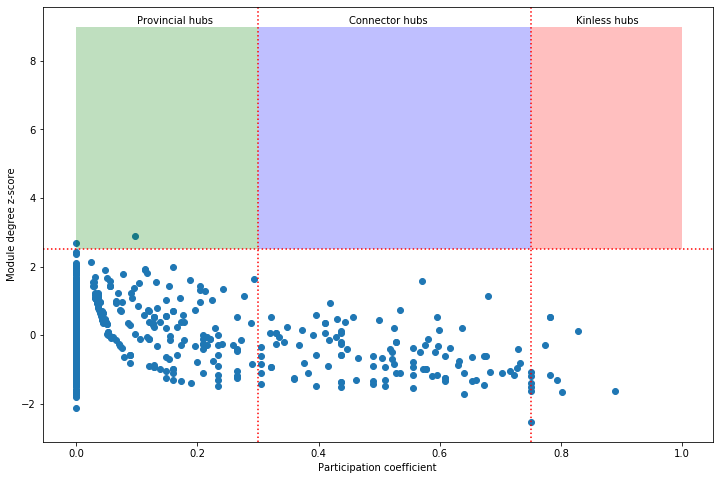

In [83]:
# put everything into a data frame
cartography=pd.DataFrame(np.vstack((pc,mdzs,
    module_degree_zscore(Gc_fmri,ml.membership,zscore=False))).T,
    columns=['PC','MDZS','ModDegree'],
    index=Gc_fmri.nodes)

plt.figure(figsize=(12,8))
plt.scatter(cartography.PC,cartography.MDZS)
ax=plt.gca()

# print names for certain hubs
for i, txt in enumerate(cartography.index):
    if  cartography.loc[txt, 'MDZS']>3 or (cartography.loc[txt, 'MDZS']>2.5 and cartography.loc[txt, 'PC']>0.75):
        ax.annotate(txt, (cartography.loc[txt, 'PC'], cartography.loc[txt, 'MDZS']))
        
# add lines and anntation for Guimera/Amaral regions
plt.axvline(0.75, color='r',linestyle='dotted')
plt.axvline(0.3, color='r',linestyle='dotted')
plt.axhline(2.5, color='r',linestyle='dotted')
plt.xlabel('Participation coefficient')
plt.ylabel('Module degree z-score')
ymax=9
ax.fill_between([0,0.3], [2.5,2.5],[ymax,ymax], facecolor='green', alpha=0.25)
ax.fill_between([0.3,0.75], [2.5,2.5],[ymax,ymax], facecolor='blue', alpha=0.25)
ax.fill_between([0.75,1.], [2.5,2.5],[ymax,ymax], facecolor='red', alpha=0.25)
plt.annotate('Provincial hubs',[0.1,ymax+0.1])
plt.annotate('Connector hubs',[0.45,ymax+0.1])
plt.annotate('Kinless hubs',[0.825,ymax+0.1])

In [81]:
mdzs.max()

2.881504767300164

In [ ]:
measure='degree'

def draw_measure_graph(measure):

    plt.figure()
    measure_std=(FB_centrality_df[measure] - 
                 min(FB_centrality_df[measure]))/max(FB_centrality_df[measure])
    nx.draw_networkx(G_facebook,pos=fb_spring_layout,
                          width=0.1,alpha=0.1,nodelist=[],
                          with_labels=False)

    idx=np.argsort(FB_centrality_df[measure])
    for i in idx:
        nx.draw_networkx_nodes(G_facebook,pos=fb_spring_layout,
                               node_size=measure_std[i]*150,
                               cmap='plasma',
                               node_color=[measure_std[i]],vmin=0,vmax=1,
                               nodelist=[i],labels=None)
    plt.title(measure)

for measure in FB_centrality_df.columns.tolist():
    print('plotting',measure)
    draw_measure_graph(measure)
    


### Simulating a realistic network

Network science has developed a number of theories to explain how complex networks come about.  One of the first models, proposed by Watts & Strogatz (1998), is to start with a ring in which each node is connected to its k nearest neighbors, and then randomly rewire connections with some probability.  The initial ring is highly clustered (since each node is connected to all of its nearest neighbors), but has a long average path length. What they found was that the inclusion of a small number of random rewirings resulted in a substantial reduction of the average path length, while still leaving the network fairly highly clustered.  They termed this a "small world" network.

We can simulate a Watts-Strogatz network using the ```connected_watts_strogatz_graph()``` function in networkx.  This is an enhanced version of the standard Watts-Strogatz simulator, which tries to find a fully connected graph, meaning that all nodes are connected to all other nodes.  We use this because it's not possible to compute average path length in a network that isn't connected, because the path between nodes in different components of the graph will be nonexistent (i.e. infinitely long).

In [ ]:
G_ws=nx.connected_watts_strogatz_graph(100,6,0.1)
nx.draw_circular(G_ws,node_size=2,node_color='red')

In [ ]:
nx.average_clustering(G_ws)

In [ ]:
nx.average_shortest_path_length(G_ws)

Watts and Strogatz famously showed that there is a range of rewiring probabilities for which the clustering coefficient remains high but the average path length decreases.  Let's simulate this and see for ourselves.

In [ ]:
nnodes=100
nruns=20 # number of simulations to run at each value
kconn=10
rewiring_probs=np.hstack((np.arange(.0001,0.001,.0001),
                             np.arange(.001,0.01,.001),
                             np.arange(.01,0.1,.01),
                             np.arange(.1,1,.1)))


cc=np.zeros(len(rewiring_probs))
apl=np.zeros(len(rewiring_probs))

for i,p in enumerate(rewiring_probs.tolist()):
    cc_tmp=np.zeros(nruns)
    apl_tmp=np.zeros(nruns)
    for r in range(nruns):
        G_tmp=nx.connected_watts_strogatz_graph(nnodes,kconn,p)
        cc_tmp[r]=nx.average_clustering(G_tmp)
        apl_tmp[r]=nx.average_shortest_path_length(G_tmp)
    cc[i]=np.mean(cc_tmp)
    apl[i]=np.mean(apl_tmp)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(np.log(rewiring_probs),cc, 'b-')
ax1.set_xlabel('log(p(rewire))')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Clustering coeff', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(np.log(rewiring_probs),apl, 'r-')
ax2.set_ylabel('Average path length', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

This plot recapitulates the result from Watts & Strogatz (1998), showing that there is a range of rewiring probabilities where the average path length is relatively short but the network is also nearly as clustered as the ring graph, which they refer to as "small world" networks.